In [ ]:
# Baseline Model for Sales Forecasting

This notebook implements the baseline model for forecasting sales using the Prophet library. It includes loading data, preprocessing, model fitting, evaluation, and visualization.

/Users/alexanderschou/Library/Caches/pypoetry/virtualenvs/at2-experimentation-YINVk6u--py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
/var/folders/mh/j3zy8xqx2v32dk0tv4nx5x8m0000gn/T/ipykernel_6552/2950966902.py:12: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  sales_train_processed = pd.read_csv(train_path)
/var/folders/mh/j3zy8xqx2v32dk0tv4nx5x8m0000gn/T/ipykernel_6552/2950966902.py:13: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  sales_test_processed = pd.read_csv(test_path)
09:23:43 - cmdstanpy - INFO - Chain [1] start processing
09:23:45 - cmdstanpy - INFO - Chain [1] done processing
/Users/alexanderschou/Library/Ca

Mean Absolute Error (MAE): 10201.263600393197
Root Mean Squared Error (RMSE): 14051.97009130396
Mean Absolute Percentage Error (MAPE): 908.06%


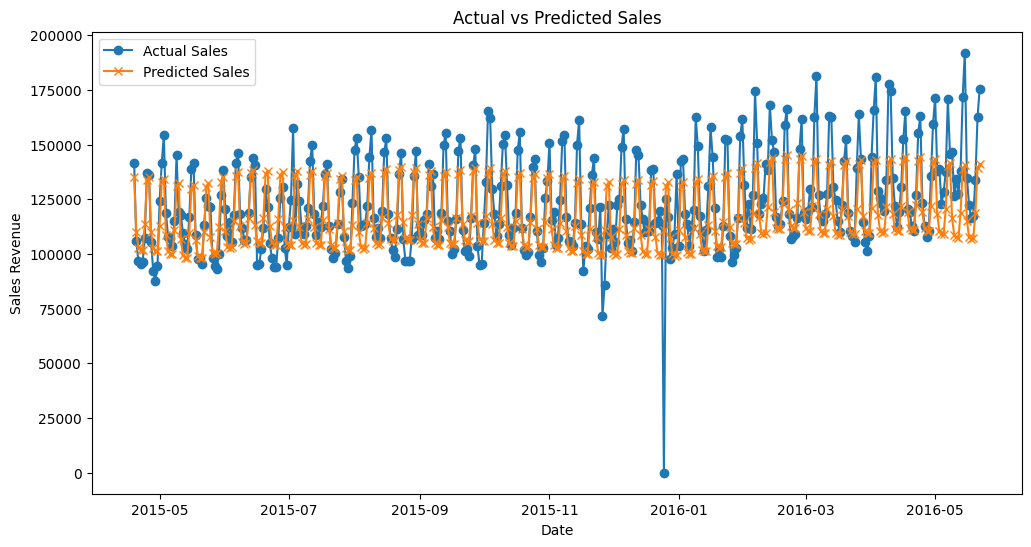

In [1]:
# Import necessary libraries
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import joblib
import os
import matplotlib.pyplot as plt

# Function to load data
def load_data(train_path, test_path):
    try:
        sales_train_processed = pd.read_csv(train_path)
        sales_test_processed = pd.read_csv(test_path)
        return sales_train_processed, sales_test_processed
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None

# Function to preprocess data
def preprocess_data(sales_train, sales_test):
    sales_train['date'] = pd.to_datetime(sales_train['date'])
    sales_test['date'] = pd.to_datetime(sales_test['date'])

    daily_sales_train = sales_train.groupby('date')['revenue'].sum().reset_index()
    daily_sales_train.rename(columns={'date': 'ds', 'revenue': 'y'}, inplace=True)

    daily_sales_test = sales_test.groupby('date')['revenue'].sum().reset_index()
    daily_sales_test.rename(columns={'date': 'ds', 'revenue': 'y'}, inplace=True)

    return daily_sales_train, daily_sales_test

# Function to fit the Prophet model
def fit_prophet_model(train_data):
    model = Prophet()
    model.fit(train_data)
    return model

# Function to evaluate the model
def evaluate_model(test_data, forecast_data):
    mae = mean_absolute_error(test_data['y'], forecast_data['yhat'])
    rmse = mean_squared_error(test_data['y'], forecast_data['yhat'], squared=False)
    mape = mean_absolute_percentage_error(test_data['y'], forecast_data['yhat']) * 100

    return mae, rmse, mape

# Function to plot forecast
def plot_forecast(actual, forecast):
    plt.figure(figsize=(12, 6))
    plt.plot(actual['ds'], actual['y'], label='Actual Sales', marker='o')
    plt.plot(forecast['ds'], forecast['yhat'], label='Predicted Sales', marker='x')
    plt.title('Actual vs Predicted Sales')
    plt.xlabel('Date')
    plt.ylabel('Sales Revenue')
    plt.legend()
    plt.show()

# Set working directory and file paths
os.chdir("/Users/alexanderschou/Desktop/Projects/adv_mla_2024/AT2_experimentation/data/processed")
train_path = 'sales_train_processed.csv'
test_path = 'sales_test_processed.csv'

# Load and preprocess data
sales_train, sales_test = load_data(train_path, test_path)
if sales_train is None or sales_test is None:
    raise Exception("Failed to load data")

daily_sales_train, daily_sales_test = preprocess_data(sales_train, sales_test)

# Fit the model
model = fit_prophet_model(daily_sales_train)

# Make predictions
future_test = model.make_future_dataframe(periods=len(daily_sales_test), include_history=False)
forecast_test = model.predict(future_test)

# Evaluate the model
forecast_test_filtered = forecast_test[['ds', 'yhat']].head(len(daily_sales_test))
evaluation_df = pd.merge(daily_sales_test, forecast_test_filtered, on='ds')
mae, rmse, mape = evaluate_model(evaluation_df, forecast_test_filtered)

# Print evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Plot results
plot_forecast(daily_sales_test, forecast_test_filtered)

# Save the model
joblib.dump(model, 'prophet_sales_model_baseline.pkl')